# Path integral through rectangular $n$-dimensional grid

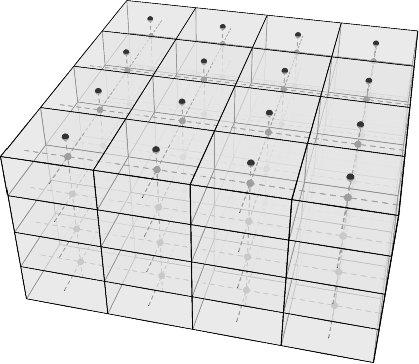

In [1]:
using Images
using FileIO
load("/home/oliver/academic/research/thesis/figures/png/spatialgrid.png")

In [2]:
using QuadGK
using Plots; pyplot()
using PerceptualColourMaps

In [3]:
function traverse_nosort_nd(f, grids, p0, p1, cm=cmap("DEPTH"))
    # Number of dimensions
    nd = length(grids)
    
    # Grid info
    nums = [length(grid) for grid in grids]
    spacings = [step(grid) for grid in grids]
    minvals = [minimum(grid) for grid in grids]
    maxvals = [maximum(grid) for grid in grids]
    
    # Direction of steps
    dirs = floor.(Int,sign.(p1-p0))
    
    # Path (parameterized by path length)
    ŝ = norm(p1-p0)
    
    # Path lengths of intersection points
    intersects = [ŝ * (grids[n]-p0[n])/(p1[n]-p0[n]) for n in 1:nd]
    
    # Initialize plot
    if nd == 2
        p = plot()
        ## MADE IT THIS FAR
        xlims!(minvals[1], maxvals[1])
        ylims!(minvals[2], maxvals[2])
        drawgrid!(grids...)
    end
    
    # Current path position
    s = 0.
    # Next path position
    s_next = 0.
    
    # Path spacing counter
    k = 1
    # Allocate spacing array
    ds = zeros(sum(nums))
    ds_max = sqrt(sum(spacings.^2))
    
    # Conversion from cell_inds to edge_inds
    # (assuming edge preceeds cell)
    shifts = [dir == 1 ? 1 : 0 for dir in dirs]
    
    # To mark grid location for abs. coef.
    cell_inds = ceil.(Int, (p0-minvals)./spacings)
    edge_inds = cell_inds .+ shifts
    
    # Initialize integral
    integ = 0.
    
    while s < ŝ
        # Determine direction and path length
        s_candidates = [intersects[n][edge_inds[n]] for n in 1:nd]
        s_next, min_ind = findmin(s_candidates)
        ds = min(s_next, ŝ) - s
        
        # EVALUATE INTEGRAL
        integ += f[cell_inds...] * ds
        
        # Plot if 2D
        if ds > 0
            if nd == 2
                drawrect!(grids[1], grids[2], cell_inds[1], cell_inds[2], ds/ds_max, cm)
            end
        end
        
        # Move to next cell
        cell_inds[min_ind] += dirs[min_ind]
        edge_inds[min_ind] += dirs[min_ind]
        s = s_next
        k += 1
    end
            
    if nd == 2
        plot!([p0[1], p1[1]], [p0[2], p1[2]]; color=:black, marker=:circle, reuse=false, legend=false)
        title!("Ray Tracing Test")
    else
        p = nothing
    end
    
    
    return integ, p
end

traverse_nosort_nd (generic function with 2 methods)

# Test numerical integration over grid vs. quadrature

In [4]:
function applyfunc(f, grids)
    """Evaluate `f` over cartesian product of grids"""
    nd = length(grids)
    
    newdims = [ones(Int, nd) for grid in grids]
    for i in 1:nd
        newdims[i][i] = length(grids[i])
    end
    
    newarrs = [reshape(grids[i], Tuple(newdims[i])) for i in 1:nd]
    
    return broadcast(f, newarrs...)
end

function compare_grid_and_quadrature(f, grids, p0, p1)
    f_arr = applyfunc(f, grids)
    
    # Numerical integration over grid
    integ, p = traverse_nosort_nd(f_arr, [x, y, z, w], p0, p1);
    if p != nothing
        display(p)
    end
    println("Ray trace: $integ")

    # Quadrature with symobolic function for more precise answer
    l̂(t) = p1*t + (1-t)*p0
    ŝ = norm(p1-p0)
    l(s) = l̂(s/ŝ)
    f_path(s) = f(l(s)...)
    quad_integ, quad_err = quadgk(f_path, 0, ŝ)
    println("Quadrature: $quad_integ")
end

compare_grid_and_quadrature (generic function with 1 method)

In [5]:
# Define problem
f(x, y, z, w) = sin.(x .+ y)  .* y.^2 .- log.(z) .+ 2*(w)

x = linspace(1, 8, 21)
y = linspace(2, 2.5, 21)
z = linspace(3, 7, 21)
w = linspace(1, 20, 21)
grids = [x, y, z, w]

p0 = [1.3, 2.4, 3.1, 1.2]
p1 = [7.4, 2.3, 6.2, 19.]

compare_grid_and_quadrature(f, grids, p0, p1)

Ray trace: 338.03998324673375
Quadrature: 356.85960233742117
